# ARTwarp VS HDBSCAN

ARTwarp is the most common accepted way to automatised the categorisation of whistle contours.
We ran ARTwarp on a part of our dataset (about 1,500 whistles, those with a duration > 1s), and it took a week to run.

Seeing this, we developped another approach using DTW + HDBSCAN.

Both methods used manual verification after the automatic categorisation. Let's compare their results.

## Importations

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

os.chdir("..")
from WCT_analysis_utils import (add_file_sequence_cols, run_SIGID, plot_wct_grid,
    plot_hue_wct_grid, categories_multi_dates, kw_test, pairwise_tests, get_stars)

### ARTwarp data importation

In [ ]:
artwarp_df = pd.read_csv(
    "./resources/ARTwarp_outputs/Verification_outputs/final_categories_1s_96percent_smooth.csv",
    index_col=0, parse_dates=["start_dt", "stop_dt"])   
artwarp_df["date"] = pd.to_datetime(artwarp_df["start_dt"].dt.date)
artwarp_df["year"] = artwarp_df["date"].dt.year
artwarp_df["clean_activation_state"] = artwarp_df["activation_state"].copy()
artwarp_df.loc[artwarp_df.clean_activation_state == 'Control', 'clean_activation_state'] = "BEF"
artwarp_df = add_file_sequence_cols(artwarp_df, "/media/loic/Extreme SSD/Acoustique")

# rename isolated whistles to -1
cat_counts = np.unique(artwarp_df.category, return_counts=True)
for cat, count in zip(cat_counts[0], cat_counts[1]):
    if count == 1:
        artwarp_df.loc[artwarp_df[artwarp_df.category == cat].index, "category"] = -1

Sequencing: 100%|██████████| 1447/1447 [00:00<00:00, 3394.72it/s]


### HDBSCAN data importation

In [3]:
hdbscan_df = pd.read_csv(
    "./resources/dtw_resources/contours_with_category.csv",
    index_col=0, parse_dates=["start_dt", "stop_dt"])

# keep rows with same index as artwarp_df
hdbscan_df = hdbscan_df.loc[artwarp_df.index]

hdbscan_df["date"] = pd.to_datetime(hdbscan_df["start_dt"].dt.date)
hdbscan_df["year"] = hdbscan_df["date"].dt.year
hdbscan_df["clean_activation_state"] = hdbscan_df["activation_state"].copy()
hdbscan_df.loc[hdbscan_df.clean_activation_state == 'Control', 'clean_activation_state'] = "BEF"

# rename isolated whistles to -1
cat_counts = np.unique(hdbscan_df.category, return_counts=True)
for cat, count in zip(cat_counts[0], cat_counts[1]):
    if cat == 0:
        hdbscan_df.loc[hdbscan_df[hdbscan_df.category == cat].index, "category"] = -1
    elif count == 1:
        hdbscan_df.loc[hdbscan_df[hdbscan_df.category == cat].index, "category"] = -1

# SIGID

Using interval 0.2-1s

In [4]:
interval = [0.2, 10]

# Identify SWTs (SIGID method)
artwarp_df = run_SIGID(artwarp_df, interval=interval)
hdbscan_df = run_SIGID(hdbscan_df, interval=interval)

# Extensive comparison
## Numbers

In [5]:
# Same number of sequences ?
print("Number of sequences:")
print("\tartwarp:", artwarp_df.sequence.nunique())
print("\thdbscan:", hdbscan_df.sequence.nunique())

Number of sequences:
	artwarp: 54
	hdbscan: 54


In [6]:
# same number of outliers ?
print("Number of outliers:")
print("\tartwarp:", (artwarp_df.category == -1).sum())
print("\thdbscan:", (hdbscan_df.category == -1).sum())

Number of outliers:
	artwarp: 847
	hdbscan: 1019


In [7]:
# ok, let's evaluate the number of missclassified outliers
artwarp_outliers = list(artwarp_df[artwarp_df.category == -1].index)
hdbscan_outliers = list(hdbscan_df[hdbscan_df.category == -1].index)

common_outliers = [outlier for outlier in artwarp_outliers if outlier in hdbscan_outliers]
artwarp_outlier_not_in_hdbscan = [outlier for outlier in artwarp_outliers if outlier not in hdbscan_outliers]
hdbscan_outlier_not_in_artwarp = [outlier for outlier in hdbscan_outliers if outlier not in artwarp_outliers]

print(f"{len(common_outliers)} outliers in common.")

798 outliers in common.


In [8]:
# same number of WCTs/SWTs ?
print("Number of WCTs:")
print("\tartwarp:", artwarp_df.category.nunique()-1)
print("\thdbscan:", hdbscan_df.category.nunique()-1)

print("Number of SWTs:")
print("\tartwarp:", artwarp_df[artwarp_df["SWT_[0.2,10]"]==1].category.nunique()-1)
print("\thdbscan:", hdbscan_df[hdbscan_df["SWT_[0.2,10]"]==1].category.nunique()-1)

Number of WCTs:
	artwarp: 159
	hdbscan: 90
Number of SWTs:
	artwarp: 40
	hdbscan: 30


So there are some differences, but iirc there were many groups of 2 contours in artwarp_df. Maybe that is where the differences come from?

In [9]:
artwarp_cat_count = artwarp_df.groupby('category').size()
hdbscan_cat_count = hdbscan_df.groupby('category').size()
print(f"ARTwarp: {(artwarp_cat_count == 2).sum()} categories with 2 elements.")
print(f"HDBSCAN: {(hdbscan_cat_count == 2).sum()} categories with 2 elements.")

ARTwarp: 70 categories with 2 elements.
HDBSCAN: 28 categories with 2 elements.


Well, it seems like I found the main reason for the differences in the number of WCTs. Associations of 2 contours are more rare with HDBSCAN since I treated 11,000+ contours, instead of 1,500+.

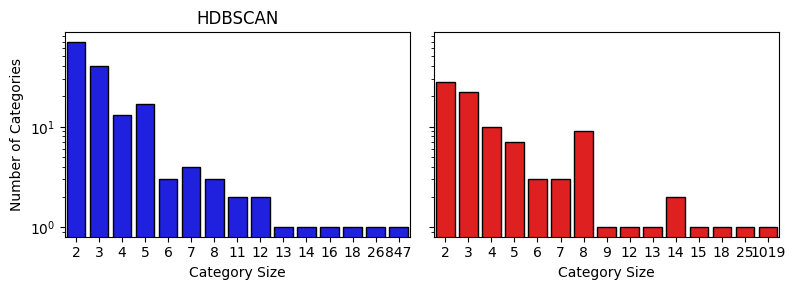

In [10]:
# show the distributions in number of elements per category
# Calculate category sizes and their frequencies
artwarp_sizes = artwarp_df['category'].value_counts()
artwarp_distribution = pd.DataFrame({
    'Category Size': artwarp_sizes.values,
    'Number of Categories': [1] * len(artwarp_sizes)
}).groupby('Category Size')['Number of Categories'].sum().reset_index()

hdbscan_sizes = hdbscan_df['category'].value_counts()
hdbscan_distribution = pd.DataFrame({
    'Category Size': hdbscan_sizes.values,
    'Number of Categories': [1] * len(hdbscan_sizes)
}).groupby('Category Size')['Number of Categories'].sum().reset_index()

# Create the bar plot
fig, axs = plt.subplots(1,2, sharey=True, figsize=(8,3))
sns.barplot(
    data=artwarp_distribution, 
    x='Category Size', y='Number of Categories',
    color="blue", edgecolor="black",
    ax=axs[0])
axs[0].set_title("ARTwarp")

sns.barplot(
    data=hdbscan_distribution, 
    x='Category Size', y='Number of Categories',
    color="red", edgecolor="black",
    ax=axs[1])
axs[0].set_title("HDBSCAN")

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.yscale('log')
plt.show()

## Detailed differences

Ok so there are some differences between 

# Compare all categories

Loop on all indexes :
- if index is an outlier in both dfs ==> perfect
- if index is in a category that is exactly the same in both dfs ==> perfect
- if index is in categories, but with different elements ==> that will require some manual work
- if index is in an outlier for on df, but not the other ==> that will also require some manual work
- else, well it should not happen.


In [11]:
perfection = []
outliers = []
check_category = []
check_contour = []
for idx, _ in tqdm(artwarp_df.iterrows(), total=len(artwarp_df)):
    # outlier in both dataframes ?
    if ((artwarp_df.loc[idx].category == -1) and (hdbscan_df.loc[idx].category == -1)):
        perfection += [idx]

    # index in a category in both dfs
    elif ((artwarp_df.loc[idx].category != -1) and (hdbscan_df.loc[idx].category != -1)):
        indexes_of_category_in_artwarp = artwarp_df[artwarp_df.category == artwarp_df.loc[idx, "category"]].index
        corr_artwarp_cat = artwarp_df.loc[indexes_of_category_in_artwarp].category.unique()

        indexes_of_category_in_hdbscan = hdbscan_df[hdbscan_df.category == hdbscan_df.loc[idx, "category"]].index
        corr_hdbscan_cat = hdbscan_df.loc[indexes_of_category_in_hdbscan].category.unique()

        # identical categories ?
        if np.all([i in indexes_of_category_in_hdbscan for i in indexes_of_category_in_artwarp]):
            perfection += [idx]

        else:
            check_category += [idx]

    # assigned as outlier in df1 but is in a category in df2 ?
    elif (artwarp_df.loc[idx].category != -1) and (hdbscan_df.loc[idx].category == -1):
        outliers += [idx]
    elif (hdbscan_df.loc[idx].category != -1) and (artwarp_df.loc[idx].category == -1):
        outliers += [idx]
    
    # else, check singular problem
    else:
        check_contour += [idx]


print(f"Found {len(perfection)} contours ({100*len(perfection)/len(artwarp_df):.2f}% of dataset) classified in the same way in both dfs.")
print(f"Found {len(outliers)} contours ({100*len(outliers)/len(artwarp_df):.2f}% of dataset) that were assigned as outliers in one df, but not in the other.")
print(f"Found {len(check_category)} contours ({100*len(check_category)/len(artwarp_df):.2f}% of dataset) that were assigned to different categories, which I should check.")
print(f"Found {len(check_contour)} contours with another type of error (should be 0).")

100%|██████████| 1447/1447 [00:00<00:00, 1974.50it/s]

Found 1045 contours (72.22% of dataset) classified in the same way in both dfs.
Found 270 contours (18.66% of dataset) that were assigned as outliers in one df, but not in the other.
Found 132 contours (9.12% of dataset) that were assigned to different categories, which I should check.
Found 0 contours with another type of error (should be 0).


So most of the contours are classified in the same categories. 28% of contours were classified differently, let's review why.

## Review differences

Change idx to see different association of categories.

common_idxs: ['7184.json', '7199.json', '7204.json', '7209.json', '7221.json', '7230.json', '7231.json']
artwarp_add: ['5763.json', '6050.json', '6112.json', '6154.json', '6563.json', '6993.json', '7012.json', '7181.json', '7228.json']
hdbscan_add: ['6105.json']


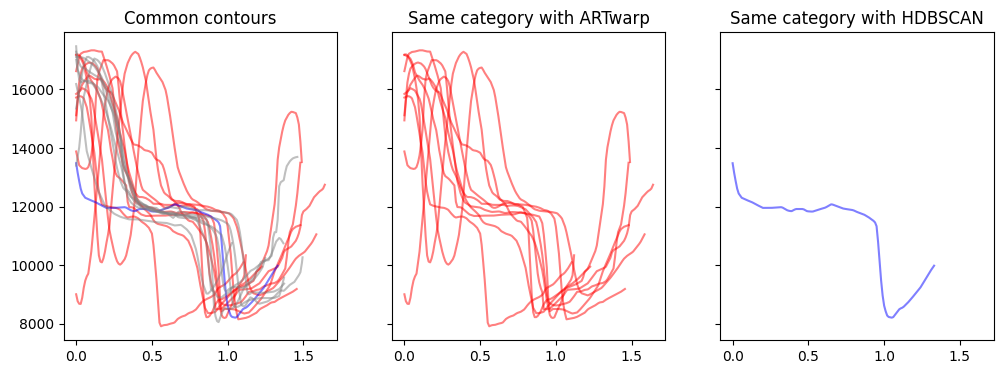

In [12]:
# For example
idx = check_category[21]

# associate categories
artwarp_cat_idxs = artwarp_df[artwarp_df.category == artwarp_df.loc[idx, "category"]].index
hdbscan_cat_idxs = hdbscan_df[hdbscan_df.category == hdbscan_df.loc[idx, "category"]].index

# find common indexes
common_idxs = [i for i in artwarp_cat_idxs if i in hdbscan_cat_idxs]

# find indexes not in common
artwarp_add = [i for i in artwarp_cat_idxs if i not in hdbscan_cat_idxs]
hdbscan_add = [i for i in hdbscan_cat_idxs if i not in artwarp_cat_idxs]

print("common_idxs:", common_idxs)
print("artwarp_add:", artwarp_add)
print("hdbscan_add:", hdbscan_add)

# Plot figure with 3 subplots : shared contours, those from artwarp, those from hdbscan.
# 1st one in B&W and the others colored with the category of the opposed method
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4))

axs[0].set_title("Common contours")
for i in common_idxs:
    with open(os.path.join("./resources/DF-whistles/smooth/all", i), "r") as f:
        coords = json.load(f)
    axs[0].plot(
        np.array(coords["time"])-min(coords["time"]), coords["frequency"],
        color="gray", zorder=10, alpha=0.5)

axs[1].set_title("Same category with ARTwarp")
for i in artwarp_add:
    with open(os.path.join("./resources/DF-whistles/smooth/all", i), "r") as f:
        coords = json.load(f)
    axs[0].plot(
        np.array(coords["time"])-min(coords["time"]), coords["frequency"],
        color="red", alpha=0.5)
    axs[1].plot(
        np.array(coords["time"])-min(coords["time"]), coords["frequency"],
        color="red", alpha=0.5)

axs[2].set_title("Same category with HDBSCAN")
for i in hdbscan_add:
    with open(os.path.join("./resources/DF-whistles/smooth/all", i), "r") as f:
        coords = json.load(f)
    axs[0].plot(
        np.array(coords["time"])-min(coords["time"]), coords["frequency"],
        color="blue", alpha=0.5)
    axs[2].plot(
        np.array(coords["time"])-min(coords["time"]), coords["frequency"],
        color="blue", alpha=0.5)
plt.show()

There are not so many "errors", it is more about human judgment. 

But ARTwarp has a huge disadvantage : it is very, very slow (it would take months to run it on our entire 11,575 whistles).

# Stats

For comparison with stats in ARTwarp analysis, if even stats are not so different, then there are no reason to keep using this method.

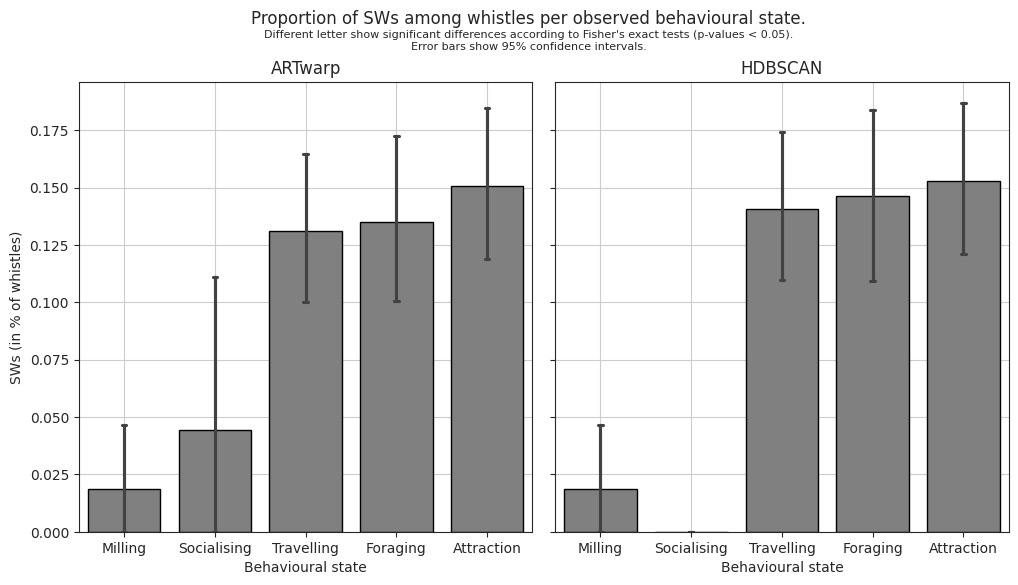

In [13]:
# Make plot
letters = ["", "", "", "", ""]
behavioural_states = ["Milling", "Socialising", "Travelling", "Foraging", "Attraction"]

sns.set_style("ticks")
fig_behaviour, axs_behaviour = plt.subplots(1,2, sharey=True)
sns.barplot(
    data=artwarp_df, x="behaviour", y="SWT_[0.2,10]",
    capsize=0.05, width=0.8, order=behavioural_states,
    n_boot=10000, seed=42, ax=axs_behaviour[0], 
    color="gray", edgecolor="black"
)
sns.barplot(
    data=hdbscan_df, x="behaviour", y="SWT_[0.2,10]",
    capsize=0.05, width=0.8, order=behavioural_states,
    n_boot=10000, seed=42, ax=axs_behaviour[1], 
    color="gray", edgecolor="black"
)

for i, x in enumerate(behavioural_states):
    axs_behaviour[0].text(
        str(x), 0.195, letters[i], ha="center", va="top", fontsize=10,
        backgroundcolor="white"
    )
    axs_behaviour[1].text(
        str(x), 0.195, letters[i], ha="center", va="top", fontsize=10,
        backgroundcolor="white"
    )
axs_behaviour[0].set_xlabel("Behavioural state")
axs_behaviour[1].set_xlabel("Behavioural state")
axs_behaviour[0].set_ylabel("SWs (in % of whistles)")
axs_behaviour[1].set_ylabel("SWs (in % of whistles)")
axs_behaviour[0].set_title("ARTwarp")
axs_behaviour[1].set_title("HDBSCAN")
fig_behaviour.suptitle("Proportion of SWs among whistles per observed behavioural state.")
fig_behaviour.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_behaviour.set_size_inches(12, 6)
fig_behaviour.subplots_adjust(
    top=0.86, wspace=0.05
)
axs_behaviour[0].xaxis.grid(True)
axs_behaviour[0].yaxis.grid(True)
axs_behaviour[1].xaxis.grid(True)
axs_behaviour[1].yaxis.grid(True)
plt.show()
sns.reset_orig()

/tmp/ipykernel_33216/3883077290.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_beacon[0].set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
/tmp/ipykernel_33216/3883077290.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_beacon[1].set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])


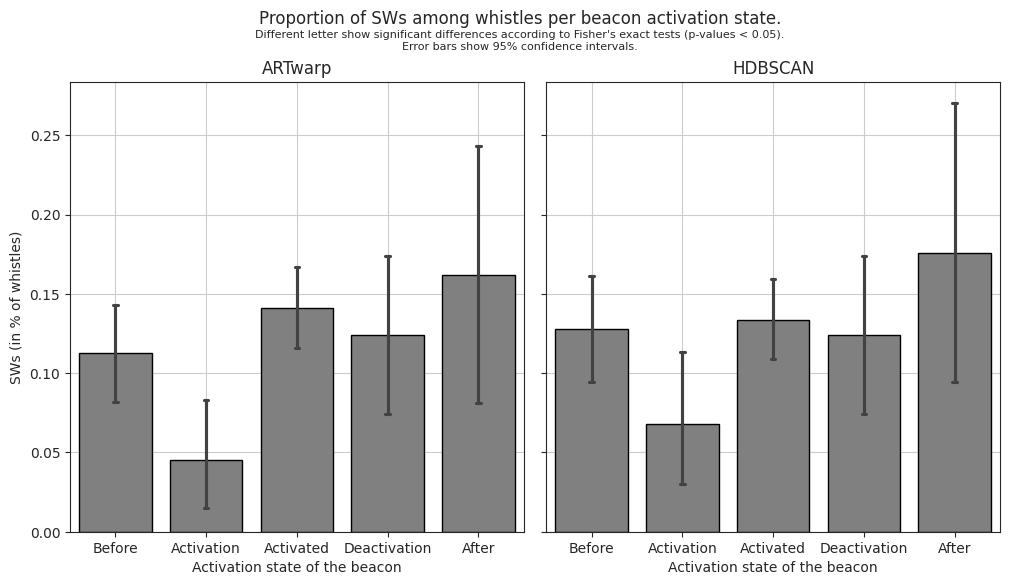

In [14]:
# Make plot
letters = ["", "", "", "", ""]
activation_order = ["BEF", "BEF+DUR", "DUR", "DUR+AFT", "AFT"]

sns.set_style("ticks")
fig_beacon, axs_beacon = plt.subplots(1,2, sharey=True)
sns.barplot(
    data=artwarp_df, x="clean_activation_state", y="SWT_[0.2,10]",
    capsize=0.05, width=0.8, order=activation_order,
    n_boot=10000, seed=10, ax=axs_beacon[0],
    color="gray", edgecolor="black"
)
sns.barplot(
    data=hdbscan_df, x="clean_activation_state", y="SWT_[0.2,10]",
    capsize=0.05, width=0.8, order=activation_order,
    n_boot=10000, seed=10, ax=axs_beacon[1],
    color="gray", edgecolor="black"
)
# since seaborn uses bootstrap, results are kinda different unfortunately.
for i, x in enumerate(activation_order):
    axs_beacon[0].text(
        str(x), 0.255, letters[i], ha="center", va="bottom", fontsize=11,
        backgroundcolor="white"
    )
    axs_beacon[1].text(
        str(x), 0.255, letters[i], ha="center", va="bottom", fontsize=11,
        backgroundcolor="white"
    )
axs_beacon[0].set_xlabel("Activation state of the beacon")
axs_beacon[0].set_ylabel("SWs (in % of whistles)")
axs_beacon[1].set_xlabel("Activation state of the beacon")
axs_beacon[1].set_ylabel("SWs (in % of whistles)")
axs_beacon[0].set_title("ARTwarp")
axs_beacon[1].set_title("HDBSCAN")
axs_beacon[0].set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
axs_beacon[1].set_xticklabels(["Before", "Activation", "Activated", "Deactivation", "After"])
fig_beacon.suptitle("Proportion of SWs among whistles per beacon activation state.")
fig_beacon.text(
    0.5, 0.91,
    "Different letter show significant differences according to Fisher's exact tests (p-values < 0.05).\nError bars show 95% confidence intervals.",
    ha="center", va="bottom", fontsize=8)
fig_beacon.set_size_inches(12, 6)
fig_beacon.subplots_adjust(
    top=0.86, wspace=0.05
)
axs_beacon[0].xaxis.grid(True)
axs_beacon[0].yaxis.grid(True)
axs_beacon[1].xaxis.grid(True)
axs_beacon[1].yaxis.grid(True)
plt.show()
sns.reset_orig()

OK !

Results are similar, categorisation is similar... Let's abandon ARTwarp for a more practical approach: DTW + HDBSCAN